### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
height = 28
width = 28
n_classes = 10
latent_dim = 100
n_channels = 1

### Building CGAN

#### Building Generator

In [3]:
def generator_model():
    image_resize = height // 4

    input_data = Input(shape=(latent_dim,), name='z_input')
    input_labels = Input(shape=(n_classes,), name='class_labels')

    x = concatenate([input_data, input_labels], axis=1)
    x = Dense(image_resize * image_resize * 128)(x)
    x = Reshape((image_resize, image_resize, 128))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=32, kernel_size=5, strides=1, padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=1, kernel_size=5, strides=1, padding='same')(x)

    x = Activation('sigmoid')(x)
    
    # input is conditioned by labels
    generator = Model(inputs=[input_data, input_labels], outputs=x, name='generator')
    return generator


In [4]:
generator = generator_model()

In [5]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)         696192      concatenate[0][0]        

#### Building Discriminator

In [6]:
def discriminator_model():
    # input image
    model_input = Input(shape=(width, height, n_channels), name='discriminator_input')
    x = model_input
    # input label
    labels = Input(shape=(n_classes,))
    
    labels_embedded = Dense(width * width)(labels)
    labels_embedded = Reshape((width, height, n_channels))(labels_embedded)

    x = concatenate([x, labels_embedded])
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(filters=256, kernel_size=5, strides=1, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # model_input is conditioned by labels
    discriminator = Model([model_input, labels], x, name='discriminator')

    return discriminator

In [7]:
discriminator = discriminator_model()

In [8]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        input_1[0][0]                    
__________________________________________________________________________________________________
discriminator_input (InputLayer [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
______________________________________________________________________________________

### Data

In [9]:
(X, y), (_, _) = tf.keras.datasets.mnist.load_data()

In [10]:
def generate_noise(type_of_noise, batch_size):
    if type_of_noise == "normal_noise":
        return np.random.normal(0, 1, size=[batch_size, latent_dim])

    elif type_of_noise == "uniform_noise":
        return np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])


In [11]:
def sample_images(epoch):
    r, c = 2, 5
    noise = np.random.uniform(-1.0, 1.0, size=[r * c, latent_dim])

    sampled_labels = np.arange(0, 10).reshape(-1, 1)
    sampled_labels_categorical = to_categorical(sampled_labels)

    gen_imgs = generator.predict([noise, sampled_labels_categorical])

    # Rescale images 0 - 1
    # gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch, bbox_inches='tight', dpi=200)
    plt.close()

In [12]:
optimizer = Adam(0.0002, 0.5)

In [13]:
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

In [14]:
noise = Input(shape=(latent_dim, ))
label = Input(shape=(n_classes,))
img = generator([noise, label])

In [15]:
# during generator updating,  the discriminator is fixed (will not be updated).
discriminator.trainable = False

In [16]:
# The discriminator takes generated image and label as input and determines its validity
validity = discriminator([img, label])

In [17]:
cgan_model = Model(inputs=[noise, label], outputs=validity)
cgan_model.compile(loss=['binary_crossentropy'],optimizer=optimizer,metrics=['accuracy'])

In [18]:
cgan_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 28, 28, 1)    1364225     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1090001     generator[1][0]              

In [20]:
 def train(x_train, y_train, epochs=1000, batch_size=128, sample_interval=50):
        x_train = np.reshape(x_train, [-1, width, height, n_channels])
        x_train = x_train.astype('float32') / 255

        y_train = to_categorical(y_train)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  --------------------- Train Discriminator ---------------------
            # Select a random half batch of images
            idx = np.random.randint(0, x_train.shape[0], size=batch_size)
            imgs, labels = x_train[idx], y_train[idx]

            # Generate sample noise for generator input
            noise = generate_noise("uniform_noise", batch_size)

            # Generate a half batch of new images
            # we can use labels instead of fake_labels; because it is fake for noise
            gen_imgs = generator.predict([noise, labels])

            # --------------------- Train the Discriminator ---------------------
            d_loss_real = discriminator.train_on_batch([imgs, labels], real)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  --------------------- Train the Generator ---------------------
            # Condition on labels (random one-hot labels)
            fake_labels = np.eye(n_classes)[np.random.choice(n_classes, batch_size)]

            # Train the generator
            cgan_loss, acc = cgan_model.train_on_batch([noise, fake_labels], real)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], cgan_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                sample_images(epoch)


In [21]:
#train(X, y, epochs=1000, batch_size=32, sample_interval=300)

### Predictions

In [173]:
generator.load_weights("weights/generator.h5")
discriminator.load_weights("weights/discriminator.h5")
cgan_model.load_weights("weights/cgan.h5")

### Single Prediction

In [162]:
noise = np.random.uniform(-1.0, 1.0, size=[1, latent_dim])


In [163]:
sampled_labels = np.arange(0, 10).reshape(-1, 1)

In [164]:
sampled_labels_categorical = to_categorical(sampled_labels)
label = np.array([sampled_labels_categorical[3]], dtype=np.float32)
label.shape

(1, 10)

In [175]:
gen_img = generator.predict([noise, label])
disc = discriminator.predict([gen_img, label])
cgan = cgan_model.predict([noise, label])

In [176]:
gen_img.shape
disc.shape
cgan.shape

(1, 1)

In [177]:
img  = gen_img * 255
img = img.astype('int32')

In [178]:
img = img.reshape(28, 28)

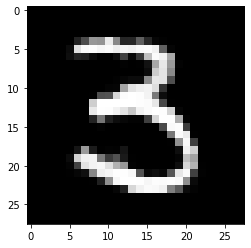

In [179]:
plt.imshow(img, cmap='gray')

### Multiple Predictions

In [181]:
for epoch in range(10):
    sample_images(epoch)